In [1]:

import gym
import random
import numpy as np
from helpers import generate_action
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv


In [2]:




# Constants
COLORS = ["blue", "green", "red"]  # Assuming 3 colors: blue, green, red
MOUSE = 0
KEY = 2
LOCKED_DOOR = 1
WORLD_DIM = 25
EMPTY = 100
BLOCKED = 51

HEIST_STATE_DICT_TEMPLATE = [
    ["int", "SERIALIZE_VERSION"],
    ["string", "game_name"],
    ["int", "options.paint_vel_info"],
    ["int", "options.use_generated_assets"],
    ["int", "options.use_monochrome_assets"],
    ["int", "options.restrict_themes"],
    ["int", "options.use_backgrounds"],
    ["int", "options.center_agent"],
    ["int", "options.debug_mode"],
    ["int", "options.distribution_mode"],
    ["int", "options.use_sequential_levels"],
    ["int", "options.use_easy_jump"],
    ["int", "options.plain_assets"],
    ["int", "options.physics_mode"],
    ["int", "grid_step"],
    ["int", "level_seed_low"],
    ["int", "level_seed_high"],
    ["int", "game_type"],
    ["int", "game_n"],
    ["int", "level_seed_rand_gen.is_seeded"],
    ["string", "level_seed_rand_gen.str"],
    ["int", "rand_gen.is_seeded"],
    ["string", "rand_gen.str"],
    ["float", "step_data.reward"],
    ["int", "step_data.done"],
    ["int", "step_data.level_complete"],
    ["int", "action"],
    ["int", "timeout"],
    ["int", "current_level_seed"],
    ["int", "prev_level_seed"],
    ["int", "episodes_remaining"],
    ["int", "episode_done"],
    ["int", "last_reward_timer"],
    ["float", "last_reward"],
    ["int", "default_action"],
    ["int", "fixed_asset_seed"],
    ["int", "cur_time"],
    ["int", "is_waiting_for_step"],
    ["int", "grid_size"],
    ["int", "ents.size"],
    [
        "loop",
        "ents",
        "ents.size",
        [
            ["float", "x"],
            ["float", "y"],
            ["float", "vx"],
            ["float", "vy"],
            ["float", "rx"],
            ["float", "ry"],
            ["int", "type"],
            ["int", "image_type"],
            ["int", "image_theme"],
            ["int", "render_z"],
            ["int", "will_erase"],
            ["int", "collides_with_entities"],
            ["float", "collision_margin"],
            ["float", "rotation"],
            ["float", "vrot"],
            ["int", "is_reflected"],
            ["int", "fire_time"],
            ["int", "spawn_time"],
            ["int", "life_time"],
            ["int", "expire_time"],
            ["int", "use_abs_coords"],
            ["float", "friction"],
            ["int", "smart_step"],
            ["int", "avoids_collisions"],
            ["int", "auto_erase"],
            ["float", "alpha"],
            ["float", "health"],
            ["float", "theta"],
            ["float", "grow_rate"],
            ["float", "alpha_decay"],
            ["float", "climber_spawn_x"],
        ],
    ],
    ["int", "use_procgen_background"],
    ["int", "background_index"],
    ["float", "bg_tile_ratio"],
    ["float", "bg_pct_x"],
    ["float", "char_dim"],
    ["int", "last_move_action"],
    ["int", "move_action"],
    ["int", "special_action"],
    ["float", "mixrate"],
    ["float", "maxspeed"],
    ["float", "max_jump"],
    ["float", "action_vx"],
    ["float", "action_vy"],
    ["float", "action_vrot"],
    ["float", "center_x"],
    ["float", "center_y"],
    ["int", "random_agent_start"],
    ["int", "has_useful_vel_info"],
    ["int", "step_rand_int"],
    ["int", "asset_rand_gen.is_seeded"],
    ["string", "asset_rand_gen.str"],
    ["int", "main_width"],
    ["int", "main_height"],
    ["int", "out_of_bounds_object"],
    ["float", "unit"],
    ["float", "view_dim"],
    ["float", "x_off"],
    ["float", "y_off"],
    ["float", "visibility"],
    ["float", "min_visibility"],
    ["int", "w"],
    ["int", "h"],
    ["int", "data.size"],
    ["loop", "data", "data.size", [["int", "i"]]],
    ["int", "num_keys"],
    ["int", "world_dim"],
    ["loop", "has_keys", "num_keys", [["int", "key_state"]]],
    ["int", "num_locked_doors"],
    ["loop", "locked_doors", "num_locked_doors", [
        ["float", "x"],
        ["float", "y"],
        ["int", "door_state"],
    ]],
    ["int", "END_OF_BUFFER"],
]



@dataclass
class StateValue:
    val: typing.Any
    idx: int


# fancy type just caused excessive checking / errors ;(
StateValues = typing.Dict[
    str, typing.Any
]  # Union[StateValue, List[StateValue], 'StateValues']]
Square = typing.Tuple[int, int]

def create_venv(num=1, start_level=100, num_levels=200):
    env_name = "procgen:procgen-heist-v0"  
    env = gym.make(env_name, start_level=start_level, num_levels=num_levels, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    return env


# def game_reset(env):
#     # Reset the game environment
#     # ...

#     # Randomly order the colors
#     state = EnvState(env.env.callmethod("get_state")[0])
#     state.randomly_order_colors()
#     env.env.callmethod("set_state", [state.state_bytes])

#     # ...

# def asset_for_type(state, obj_type, obj_theme):
#     if obj_type == KEY:
#         color_order = state.get_color_order()
#         color = color_order[obj_theme]
#         return f"misc_assets/key{color.capitalize()}.png"
#     elif obj_type == LOCKED_DOOR:
#         color_order = state.get_color_order()
#         color = color_order[obj_theme]
#         return f"misc_assets/lock_{color}.png"
#     # ... (code for other object types) ...

# def render_game_frame(state):
#     frame = np.zeros((WORLD_DIM, WORLD_DIM, 3), dtype=np.uint8)

#     for obj in state.get_objects():
#         obj_type = obj["type"]
#         obj_theme = obj["image_theme"]
#         asset = asset_for_type(state, obj_type, obj_theme)

#         # Load the asset image and draw it on the frame
#         # ...

#     return frame



# # Main game loop
# def play_game():
#     env = create_venv(num=1, start_level=0, num_levels=1)

#     while True:
#         game_reset(env)
#         state = EnvState(env.env.callmethod("get_state")[0])

#         while not done:
#             action = choose_action(state)
#             obs, reward, done, info = env.step(action)
#             state = EnvState(env.env.callmethod("get_state")[0])
#             frame = render_game_frame(state)
#             # Display the frame
#             # ...

#         # Game over logic
#         # ...



In [3]:
def load_model( model_path = '../model_1501.0_interpretable.pt'):
    env_name = "procgen:procgen-heist-v0"  

    env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model



def wrap_venv(venv) -> ToBaselinesVecEnv:
    "Wrap a vectorized env, making it compatible with the gym apis, transposing, scaling, etc."
    # TODO: Move this to another file (same thing is used for coinrun)

    venv = ToBaselinesVecEnv(venv)  # gym3 env to gym env converter
    venv = VecExtractDictObs(venv, "rgb")

    venv = TransposeFrame(venv)
    venv = ScaledFloatFrame(venv)
    return venv  # type: ignore - ToBaselinesVecEnv gives best type annotations



def create_venv(
    num: int, start_level: int, num_levels: int, num_threads: int = 1
):
    """
    Create a wrapped venv. See https://github.com/openai/procgen#environment-options for params

    num=1 - The number of parallel environments to create in the vectorized env.

    num_levels=0 - The number of unique levels that can be generated. Set to 0 to use unlimited levels.

    start_level=0 - The lowest seed that will be used to generated levels. 'start_level' and 'num_levels' fully specify the set of possible levels.
    """
    venv = ProcgenGym3Env(
        num=num,
        env_name="heist",
        num_levels=num_levels,
        start_level=100,
        distribution_mode="easy",
        num_threads=num_threads,
        render_mode="rgb_array",
        # rand_region=5,
    )
    venv = wrap_venv(venv)
    return venv
    
def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=2):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        observation= np.squeeze(observation)
        observation =np.transpose(observation, (2,1,0))
        print(observation.shape)
        action = generate_action(model, observation) 
        print(action) 
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

model = load_model()

In [4]:
env = ProcgenGym3Env(num=1, env_name="heist", render_mode="rgb_array")
# env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
state = env.callmethod("get_state")[0]

# Analyze the game state
print("Game state:")
print(state)

# Modify specific values in the game state
modified_state = bytearray(state)


Game state:
b'\x00\x00\x00\x00\x05\x00\x00\x00heist\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\x7f\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x003\x1a\x00\x00883545931 843453337 1800510560 914987849 862147794 1481824480 149354956 56801668 3990279453 1235296992 677653456 2108135708 2950360446 1490750970 2395264790 4233006836 2990642820 320346352 1550468803 488225950 292157547 2209170765 3869024066 2479594941 720991092 2338300126 1607742183 3393137370 1355352250 2518254821 4135718466 2864146629 1390400932 4012349243 1293132091 3399263750 1791569182 442328161 204964716 2939135428 2918014279 1316141411 3257308629 2688721818 2097079077 505012578 998333913 3526502349 3283677815 3269704694 1126319324 4050284645 1341058675 66917680 3615493159 285216364 2981199061 884363277 153061980 318821000 297129957 

In [5]:
save_gif_option = True  
env_name = "procgen:procgen-heist-v0"  
for episode in range(1):
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="hard") #remove render mode argument to go faster but not produce images
    
    env = create_venv(1,0,5)
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

(64, 64, 3)
1


AttributeError: 'int' object has no attribute 'astype'

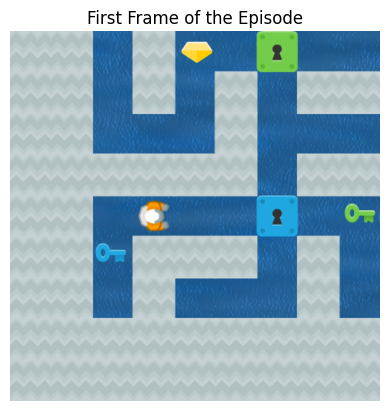

In [ ]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

In [7]:


DEBUG = (
    False  # slows everything down by ensuring parse & serialize are inverses.
)

def inner_grid(grid: np.ndarray, assert_=True) -> np.ndarray:
    """
    Get the inside of the maze, ie. the stuff within the outermost walls.
    inner_grid(inner_grid(x)) = inner_grid(x) for all x.
    """
    # Find the amount of padding on the maze, where padding is BLOCKED
    # Use numpy to test if each square is BLOCKED
    # If it is, then it's part of the padding
    bl = 0
    # Check if the top, bottom, left, and right are all blocked
    while (
        (grid[bl, :] == BLOCKED).all()
        and (grid[-bl - 1, :] == BLOCKED).all()
        and (grid[:, bl] == BLOCKED).all()
        and (grid[:, -bl - 1] == BLOCKED).all()
    ):
        bl += 1

    return (
        grid[bl:-bl, bl:-bl] if bl > 0 else grid
    )  # if bl == 0, then we don't need to do anything


def outer_grid(grid: np.ndarray, assert_=True) -> np.ndarray:
    """
    The inverse of inner_grid(). Could also be called "pad_grid".
    """
    bl = (WORLD_DIM - len(grid)) // 2
    outer = np.pad(grid, bl, "constant", constant_values=BLOCKED)
    if assert_:
        assert (inner_grid(outer, assert_=False) == grid).all()
    return outer

def get_legal_mouse_positions(grid: np.ndarray, entities: List[Dict[str, StateValue]]):
    """Return a list of legal mouse positions in the grid, returned as a list of tuples."""
    occupied_positions = set()
    for entity in entities:
        x = entity["x"].val
        y = entity["y"].val
        
        if math.isnan(x):
            x = 0  # Or any other default value or handling logic
        if math.isnan(y):
            y = 0  # Or any other default value or handling logic
        
        ex = math.floor(x)
        ey = math.floor(y)
        occupied_positions.add((ex, ey))

    legal_positions = [
        (x, y)
        for x in range(grid.shape[0])
        for y in range(grid.shape[1])
        if grid[x, y] == EMPTY and (x, y) not in occupied_positions
    ]
    
    return legal_positions


class EnvState:
    def __init__(self, state_bytes: bytes):
        self.state_bytes = state_bytes

    @property
    def state_vals(self):
        return _parse_maze_state_bytes(self.state_bytes)

    @property
    def world_dim(self):
        return self.state_vals["world_dim"].val

    def full_grid(self, with_mouse=True):
        "Get numpy (world_dim, world_dim) grid of the maze. Includes the mouse by default."
        world_dim = self.world_dim
        grid = np.array(
            [dd["i"].val for dd in self.state_vals["data"]]
        ).reshape(world_dim, world_dim)
        if with_mouse:
            grid[self.mouse_pos] = MOUSE

        return grid

    def inner_grid(self, with_mouse=True):
        "Get inner grid of the maze. Includes the mouse by default."
        return inner_grid(self.full_grid(with_mouse=with_mouse))

    @property
    def mouse_pos(self) -> Tuple[int, int]:
        "Get (x, y) position of mouse in grid."
        ents = self.state_vals["ents"][0]
        # flipped turns out to be oriented right for grid.
        return int(ents["y"].val), int(ents["x"].val)

    def set_mouse_pos(self, x: int, y: int):
        """
        Set the mouse position in the maze state bytes. Much more optimized than parsing and serializing the whole state.
        *WARNING*: This uses *outer coordinates*, not inner.
        """
        # FIXME(slow): grabbing state_vals requires a call to parse the state bytes.
        state_vals = self.state_vals
        state_vals["ents"][0]["x"].val = float(y) + 0.5
        state_vals["ents"][0]["y"].val = float(x) + 0.5
        self.state_bytes = _serialize_maze_state(state_vals)

    def get_key_colors(self):
        key_colors = []
        state_values = self.state_vals
        
        for ents in state_values["ents"]:
            if ents["image_type"].val == 2:  # Check if the entity is a key
                key_index = ents["image_theme"].val
                key_color = self.get_key_color(key_index)
                
                if key_color not in key_colors:
                    key_colors.append(key_color)
        
        return key_colors

    def get_key_color(self, key_index):
        # Map key index to color
        key_colors = {
            0: 'blue',
            1: 'green',
            2: 'red',
            # Add more key index to color mappings as needed
        }
        
        return key_colors.get(key_index, 'unknown')

    def set_key_position(self, key_index, x, y):
        state_values = self.state_vals
        for ents in state_values["ents"]:
            if ents["image_type"].val== 2:
                if key_index == ents["image_theme"].val:
                    ents["x"].val = float(y) + .5
                    ents["y"].val = float(x) + .5
        self.state_bytes = _serialize_maze_state(state_values)

    def set_lock_position(self, key_index, x, y):
        state_values = self.state_vals
        for ents in state_values["ents"]:
            if ents["image_type"].val== 1:
                if key_index == ents["image_theme"].val:
                    ents["x"].val = float(y) + .5
                    ents["y"].val = float(x) + .5
        self.state_bytes = _serialize_maze_state(state_values)

    def set_gem_position(self, x, y):
        state_values = self.state_vals
        for ents in state_values["ents"]:
            if ents["image_type"].val== 9:
                ents["x"].val = float(y) + .5
                ents["y"].val = float(x) + .5
        self.state_bytes = _serialize_maze_state(state_values)
    


    def set_grid(self, grid: np.ndarray, pad=False):
        """
        Set the grid of the maze.
        """
        if pad:
            grid = outer_grid(grid, assert_=False)
        assert grid.shape == (self.world_dim, self.world_dim)

        state_vals = self.state_vals
        grid = grid.copy()  # might need to remove mouse if in grid
        if (grid == MOUSE).sum() > 0:
            x, y = get_mouse_pos(grid)

            state_vals["ents"][0]["x"].val = (
                float(y) + 0.5
            )  # flip again to get back to original orientation
            state_vals["ents"][0]["y"].val = float(x) + 0.5

            grid[x, y] = EMPTY

        world_dim = state_vals["world_dim"].val
        assert grid.shape == (world_dim, world_dim)
        for i, dd in enumerate(state_vals["data"]):
            dd["i"].val = int(grid.ravel()[i])

        self.state_bytes = _serialize_maze_state(state_vals)
    
    def remove_all_entities(self):
        state_values = self.state_vals
        for ents in state_values["ents"]:
            ents["x"].val = -1
            ents["y"].val = -1
        self.state_bytes = _serialize_maze_state(state_values)


            

def get_mouse_pos_sv(state_vals: StateValues) -> Square:
    """Get the mouse position from state_vals"""
    ents = state_vals["ents"][0]
    return int(ents["y"].val), int(ents["x"].val)

def get_mouse_pos(
    grid: np.ndarray, flip_y: bool = False
) -> typing.Tuple[int, int]:
    "Get (x, y) position of the mouse in the grid"
    num_mouses = (grid == MOUSE).sum()
    assert num_mouses == 1, f"{num_mouses} mice, should be 1"
    row, col = np.where(grid == MOUSE)
    row, col = row[0], col[0]
    return ((WORLD_DIM - 1) - row if flip_y else row), col



@dataclass
class StateValue:
    val: typing.Any
    idx: int

StateValues = typing.Dict[
    str, typing.Any
]  # Union[StateValue, List[StateValue], 'StateValues']]
Square = typing.Tuple[int, int]


def state_from_venv(venv, idx: int = 0) -> EnvState:
    """
    Get the maze state from the venv.
    """
    state_bytes_list = venv.env.callmethod("get_state")
    return EnvState(state_bytes_list[idx])

def _parse_maze_state_bytes(state_bytes: bytes, assert_=DEBUG) -> StateValues:
    # Functions to read values of different types
    def read_fixed(sb, idx, fmt):
        sz = struct.calcsize(fmt)
        # print(f'{idx} chomp {sz} got {len(sb[idx:(idx+sz)])} fmt {fmt}')
        val = struct.unpack(fmt, sb[idx : (idx + sz)])[0]
        idx += sz
        return val, idx

    read_int = lambda sb, idx: read_fixed(sb, idx, "@i")
    read_float = lambda sb, idx: read_fixed(sb, idx, "@f")

    def read_string(sb, idx):
        sz, idx = read_int(sb, idx)
        val = sb[idx : (idx + sz)].decode("ascii")
        idx += sz
        return val, idx

    # Function to process a value definition and return a value (called recursively for loops)
    def parse_value(vals, val_def, idx):
        typ = val_def[0]
        name = val_def[1]
        # print((typ, name))
        if typ == "int":
            val, idx = read_int(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == "float":
            val, idx = read_float(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == "string":
            val, idx = read_string(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == "loop":
            len_name = val_def[2]
            loop_val_defs = val_def[3]
            loop_len = vals[len_name].val
            vals[name] = []
            for _ in range(loop_len):
                vals_this = {}
                for loop_val_def in loop_val_defs:
                    idx = parse_value(vals_this, loop_val_def, idx)
                vals[name].append(vals_this)
        return idx

    # Dict to hold values
    vals = {}

    # Loop over list of value defs, parsing each
    idx = 0
    for val_def in HEIST_STATE_DICT_TEMPLATE:
        idx = parse_value(vals, val_def, idx)




    if assert_:
        assert (
            _serialize_maze_state(vals, assert_=False) == state_bytes
        ), "serialize(deserialize(state_bytes)) != state_bytes"
    return vals

def _serialize_maze_state(state_vals: StateValues, assert_=DEBUG) -> bytes:
    # Serialize any value to a bytes object
    def serialize_val(val):
        if isinstance(val, StateValue):
            val = val.val
        if isinstance(val, int):
            return struct.pack("@i", val)
        elif isinstance(val, float):
            return struct.pack("@f", val)
        elif isinstance(val, str):
            return serialize_val(len(val)) + val.encode("ascii")
        else:
            raise ValueError(f"type(val)={type(val)} not handled")

    # Flatten the nested values into a single list of primitives
    def flatten_vals(vals, flat_list=[]):
        if isinstance(vals, dict):
            for val in vals.values():
                flatten_vals(val, flat_list)
        elif isinstance(vals, list):
            for val in vals:
                flatten_vals(val, flat_list)
        else:
            flat_list.append(vals)

    # Flatten the values, then serialize
    flat_vals = []
    flatten_vals(state_vals, flat_vals)

    state_bytes = b"".join([serialize_val(val) for val in flat_vals])

    if assert_:
        assert (
            _parse_maze_state_bytes(state_bytes, assert_=False) == state_vals
        ), "deserialize(serialize(state_vals)) != state_vals"
    return state_bytes



def test_state_parsing():
    # env_name = "procgen:procgen-heist-v0" 
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") 
    env = create_venv(num = 5, start_level=100, num_levels=5)

    state_bytes = env.env.callmethod("get_state")
    
    state_values = _parse_maze_state_bytes(state_bytes)

    state = _serialize_maze_state(state_values)

    env.env.callmethod("set_state", state)
    print(state)
    
    
    # Access specific state values
    world_dim = state_values["world_dim"].val
    grid_size = state_values["grid_size"].val
    # grid_data = state_values["grid_data"]
    
    print("World Dimension:", world_dim)
    print("Grid Size:", grid_size)
    return state_values, env

# state_values, env= test_state_parsing()
# data = state_values["data"]
# frame = env.render(mode='rgb_array')
# observation = env.reset()


# if frames:
    
#     plt.imshow(frame)
#     plt.title("First Frame of the Episode")
#     plt.axis('off')  
#     plt.show()
# else:
#     print("No frames captured.")

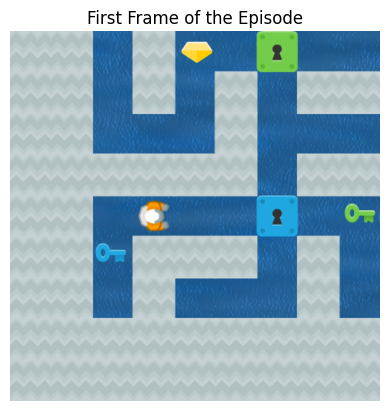

In [8]:
venv = create_venv(num = 1, start_level=0, num_levels=5)
frame = venv.render(mode='rgb_array')

plt.imshow(frame)
plt.title("First Frame of the Episode")
plt.axis('off')  
plt.show()


In [9]:
def test_function(state):
    full_grid = state.full_grid(with_mouse=False)
    entities = state.state_vals["ents"]
    legal_mouse_positions = get_legal_mouse_positions(full_grid, entities)

    state.remove_all_entities()
    print(entities)
    x,y = legal_mouse_positions[4]

    state.set_lock_position(1, x, y)
    x,y = legal_mouse_positions[5]

    state.set_key_position(0,x,y)
    x,y = legal_mouse_positions[6]
    state.set_gem_position(x,y)
    x,y = legal_mouse_positions[7]
    state.set_mouse_pos(x,y)

    return state

[{'x': StateValue(val=3.5, idx=13537), 'y': StateValue(val=4.5, idx=13541), 'vx': StateValue(val=0.0, idx=13545), 'vy': StateValue(val=0.0, idx=13549), 'rx': StateValue(val=0.375, idx=13553), 'ry': StateValue(val=0.375, idx=13557), 'type': StateValue(val=0, idx=13561), 'image_type': StateValue(val=0, idx=13565), 'image_theme': StateValue(val=0, idx=13569), 'render_z': StateValue(val=1, idx=13573), 'will_erase': StateValue(val=0, idx=13577), 'collides_with_entities': StateValue(val=0, idx=13581), 'collision_margin': StateValue(val=0.0, idx=13585), 'rotation': StateValue(val=0.0, idx=13589), 'vrot': StateValue(val=0.0, idx=13593), 'is_reflected': StateValue(val=0, idx=13597), 'fire_time': StateValue(val=-1, idx=13601), 'spawn_time': StateValue(val=-1, idx=13605), 'life_time': StateValue(val=0, idx=13609), 'expire_time': StateValue(val=-1, idx=13613), 'use_abs_coords': StateValue(val=0, idx=13617), 'friction': StateValue(val=1.0, idx=13621), 'smart_step': StateValue(val=1, idx=13625), 'av

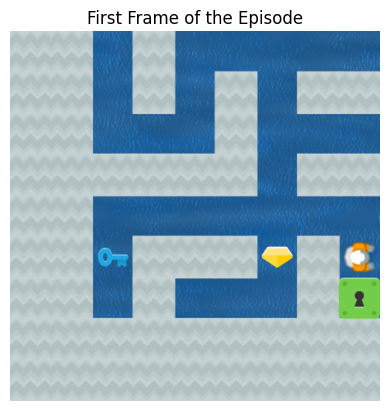

In [10]:

idx = 0
state_bytes_list = venv.env.callmethod("get_state")
state = state_from_venv(venv, 0)

state = test_function(state)
state_bytes_list[idx] = state.state_bytes
venv.env.callmethod("set_state", state_bytes_list)
frame = venv.render(mode='rgb_array')

plt.imshow(frame)
plt.title("First Frame of the Episode")
plt.axis('off')  
plt.show()

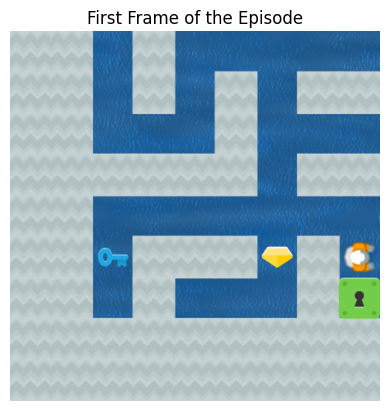

In [11]:

obs = venv.reset()
frame = venv.render(mode='rgb_array')

plt.imshow(frame)
plt.title("First Frame of the Episode")
plt.axis('off')  
plt.show()

In [12]:
env.action_space.sample()

5

In [13]:
state = state_from_venv(venv, 0)
ents = state.state_vals["ents"]
ents


[{'x': StateValue(val=8.5, idx=13537),
  'y': StateValue(val=3.5, idx=13541),
  'vx': StateValue(val=0.0, idx=13545),
  'vy': StateValue(val=0.0, idx=13549),
  'rx': StateValue(val=0.375, idx=13553),
  'ry': StateValue(val=0.375, idx=13557),
  'type': StateValue(val=0, idx=13561),
  'image_type': StateValue(val=0, idx=13565),
  'image_theme': StateValue(val=0, idx=13569),
  'render_z': StateValue(val=1, idx=13573),
  'will_erase': StateValue(val=0, idx=13577),
  'collides_with_entities': StateValue(val=0, idx=13581),
  'collision_margin': StateValue(val=0.0, idx=13585),
  'rotation': StateValue(val=0.0, idx=13589),
  'vrot': StateValue(val=0.0, idx=13593),
  'is_reflected': StateValue(val=0, idx=13597),
  'fire_time': StateValue(val=-1, idx=13601),
  'spawn_time': StateValue(val=-1, idx=13605),
  'life_time': StateValue(val=0, idx=13609),
  'expire_time': StateValue(val=-1, idx=13613),
  'use_abs_coords': StateValue(val=0, idx=13617),
  'friction': StateValue(val=1.0, idx=13621),
  'sm

In [14]:
def get_maze_structure(data):
    positions = []
    for i, cell in enumerate(data):
        if 'i' in cell and cell['i'].val == 51:
            positions.append(i)
    return positions

def get_keys(state_values):
    positions = []
    for ents in state_values["ents"]:
        if ents["image_type"].val== 2:
            print(ents)
            positions.append({"x" :ents["x"].val, "y" :ents["y"].val, "alpha" : ents["alpha"].val})
    return positions

In [15]:
def create_key_states(venv, key_colors, num_samples=5):
    state_bytes_list = [None] * venv.num_envs
    samples_created = 0
    correct_samples = 0

    for idx in range(venv.num_envs):
        state = state_from_venv(venv, idx)
        
        if not all(color in state.get_key_colors() for color in key_colors):
            state_bytes_list[idx] = state.state_bytes
            continue
        
        state.remove_all_entities()
        full_grid = state.full_grid(with_mouse=False)
        entities = state.state_vals["ents"]
        legal_mouse_positions = get_legal_mouse_positions(full_grid, entities)
        
        for i in range(len(key_colors)):
            x, y = legal_mouse_positions[(idx + i) % len(legal_mouse_positions)]
            state.set_key_position(i, x, y)
        
        state_bytes_list[idx] = state.state_bytes
        samples_created += 1
        
        if samples_created == num_samples:
            break
    
    venv.env.callmethod("set_state", state_bytes_list)
    frame = venv.render(mode='rgb_array')
    plt.imshow(frame)
    plt.title("First Frame of the Episode")
    plt.axis('off')
    plt.show()

# Usage example
num_samples = 5
num_levels = 15

venv_blue = create_venv(num=num_levels, start_level=0, num_levels=num_levels)
create_key_states(venv_blue, ['blue'], num_samples)

venv_green = create_venv(num=num_levels, start_level=0, num_levels=num_levels)
create_key_states(venv_green, ['green'], num_samples)

venv_blue_green = create_venv(num=num_levels, start_level=0, num_levels=num_levels)
create_key_states(venv_blue_green, ['blue', 'green'], num_samples)

TypeError: object of type 'NoneType' has no len()

In [ ]:
def create_key_states(venv, key_color_combinations, num_samples=5):
    num_envs = venv.num_envs
    num_combinations = len(key_color_combinations)
    required_samples = num_samples * num_combinations


    
    if num_envs < required_samples:
        raise ValueError(f"Insufficient number of environments. Required: {required_samples}, Actual: {num_envs}")
    
    state_bytes_list = [None] * num_envs
    samples_created = [0] * num_combinations
    
    for idx in range(num_envs):
        state = state_from_venv(venv, idx)
        
        if not all(color in state.get_key_colors() for color in ['blue', 'green', 'red']):
            continue
        
        combination_idx = idx % num_combinations
        key_colors = key_color_combinations[combination_idx]
        
        if samples_created[combination_idx] == num_samples:
            continue
        
        state.remove_all_entities()
        full_grid = state.full_grid(with_mouse=False)
        entities = state.state_vals["ents"]
        legal_mouse_positions = get_legal_mouse_positions(full_grid, entities)
        
            
        for i, color in enumerate(key_colors):
            key_index = key_indices[color]
            x, y = legal_mouse_positions[i % len(legal_mouse_positions)]
            state.set_key_position(key_index, x, y)
        
        state_bytes = state.state_bytes
        if state_bytes is not None:
            state_bytes_list[idx] = state_bytes
            samples_created[combination_idx] += 1
    
    valid_state_bytes_list = [state_bytes for state_bytes in state_bytes_list if state_bytes is not None]
    
    if valid_state_bytes_list:
        venv.env.callmethod("set_state", valid_state_bytes_list)
        frame = venv.render(mode='rgb_array')
        plt.imshow(frame)
        plt.title("First Frame of the Episode")
        plt.axis('off')
        plt.show()
    else:
        print("No valid states found for the given key color combinations.")

# Usage example
num_samples = 5
num_levels = 120
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]

venv = create_venv(num=num_levels, start_level=0, num_levels=num_levels)
create_key_states(venv, key_color_combinations, num_samples)

AssertionError: 

In [75]:
def create_key_states(key_color_combinations, num_samples=5, num_levels=100):
    observations_list = [[] for _ in range(num_samples)]
    key_indices = {"blue": 0, "green": 1, "red": 2}

    sample_idx = 0
    while sample_idx < num_samples:
        venv = create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
        state = state_from_venv(venv, 0)

        if not all(color in state.get_key_colors() for color in ['blue', 'green', 'red']):
            venv.close()
            continue

        for key_colors in key_color_combinations:
            state.remove_all_entities()
            full_grid = state.full_grid(with_mouse=False)
            entities = state.state_vals["ents"]
            legal_mouse_positions = get_legal_mouse_positions(full_grid, entities)

            for i, color in enumerate(key_colors):
                key_index = key_indices[color]
                x, y = legal_mouse_positions[random.randint(0, len(legal_mouse_positions) - 1)]
                state.set_key_position(key_index, x, y)

            state_bytes = state.state_bytes
            if state_bytes is not None:
                venv.env.callmethod("set_state", [state_bytes])
                obs = venv.reset()
                observations_list[sample_idx].append(obs[0])

        venv.close()
        sample_idx += 1

    return observations_list

# Usage example
num_samples = 5
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = create_key_states(key_color_combinations, num_samples, num_levels)

In [76]:
len(observations_list)

5

In [74]:
plt.imshow(observations_list[3][2].transpose(1, 2, 0))
plt.title("First Frame of the Episode")
plt.axis('off')
plt.show()

IndexError: list index out of range

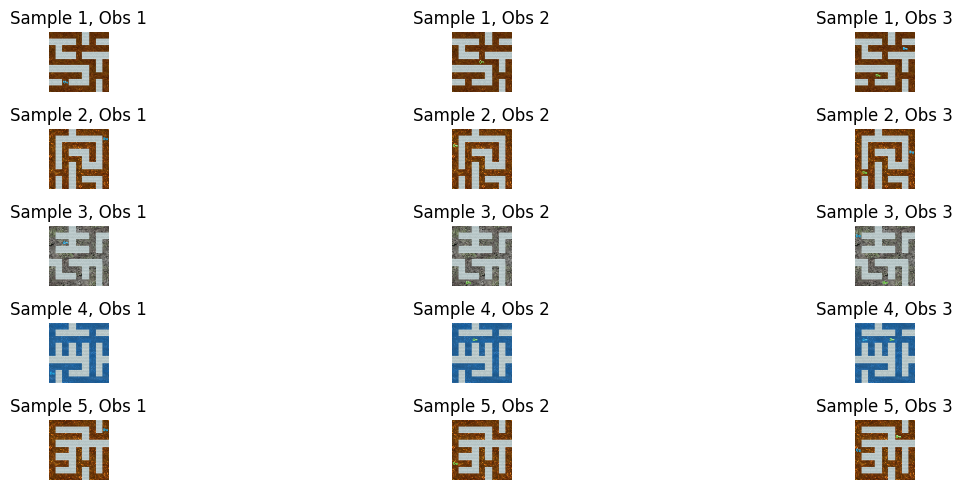

In [77]:
import itertools
fig, axs = plt.subplots(5, 3, figsize=(15, 5))  # Adjusted to create a 5x3 grid
for (i, j), obs in zip(itertools.product(range(5), range(3)), itertools.chain.from_iterable(observations_list)):
    axs[i, j].imshow(obs.transpose(1, 2, 0))
    axs[i, j].set_title(f"Sample {i+1}, Obs {j+1}")
    axs[i, j].axis('off')
plt.tight_layout()
plt.show()
